In [99]:
!pip install -q pyannote.audio pyannote.core

import torch
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyannote.audio.utils.signal import Binarize, Peak
from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline
from IPython.display import clear_output
import soundfile as sf
import librosa
from sklearn.cluster import KMeans, SpectralClustering
import seaborn as sns
from pydub import AudioSegment
from random import seed, shuffle

#Removed participant 17 (17XX) because they said hi or had a background noise
#See google doc for reference: https://docs.google.com/spreadsheets/d/1-K3pIs9BPLAsvY3_AYHyIfsLdbo0bF9XD1-ohPeZJJk/edit#gid=1936393955

## HELLOS Paths###
#raw='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input'
#directory='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input_downsampled'
#concat_dir='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\concat_samp'
#dataloc=os.path.join(concat_dir, str(seedno))

###Sentences paths###
raw='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Full_Readings\\raw'
directory='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Full_Readings\\downsamp'
#concat_dir='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\concat_samp'
dataloc=directory


#Specify path to codec exe used by pydub
AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'


# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
C:\Users\MrBrito\miniconda3\lib\site-packages\pyannote\audio\embedding\approaches\arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)


In [9]:
## DONT NEED TO RERUN
for filename in os.listdir(raw):
    if filename.endswith(".wav"):
        clear_output(wait=True)
        new_rate = 16000
        resamp, rate = librosa.load(os.path.join(raw, filename), sr=new_rate)
        sf.write(os.path.join(directory, filename), resamp, new_rate)
        print("processing" + str(filename))

In [ ]:
## DONT RUN

#d = []
#for filename in os.listdir(precrop):
#    if filename.endswith(".wav"): 
#        clear_output(wait=True)
#        one_file = {'uri': 'filename', 'audio': os.path.join(precrop, filename)}
#        
#        #detect speaker time versus silence in sample
 #       sad_scores = sad(one_file)
 #       binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, min_duration_off=0.1, min_duration_on=0.1)
 #       speech = binarize.apply(sad_scores, dimension=1)
 #       
 #       audio = AudioSegment.from_wav(os.path.join(precrop, filename))
 #       for segment in speech:
 #           d.append(segment.duration)
 #           audio_chunk=audio[segment.start*1000: segment.end*1000]
 #       audio_chunk.export(os.path.join(directory, filename), format="wav")
 #       print("Processing" + str(filename))

In [332]:
seedno=1
seed(seedno)
samples= []
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        samples.append(filename[0:4])

samples = np.reshape(samples, (17,30))
[shuffle(f) for f in samples[:]]
samples = np.reshape(samples, (17,10,3))

for f in samples[:][:]:
    for i in f:
        clear_output(wait=True)
        first = AudioSegment.from_wav(os.path.join(directory, i[0]+'.wav'))
        second = AudioSegment.from_wav(os.path.join(directory, i[1]+'.wav'))
        third = AudioSegment.from_wav(os.path.join(directory, i[2]+'.wav'))
        concat = first + second + third
        concat.export(os.path.join(dataloc,i[0]+'_'+i[1] + '_' + i[2]+'.wav'), format="wav")
        print("Processing" + i[0]+'_'+i[1] + '_' + i[2])

Processing1813_1821_1805


In [482]:
X = np.empty((1,512), dtype=float)
X = np.delete(X, (0), axis=0)
for filename in os.listdir(dataloc):
    if filename.endswith(".wav"): 
        clear_output(wait=True)
        one_file = {'uri': 'filename', 'audio': os.path.join(dataloc, filename)}
        
        #extract speaker embeddings and crop only part with speech and remove silence
        embeddings = emb(one_file)
        X = np.concatenate((X, embeddings.data), axis=0)
            


In [164]:
X, sid_per_sample, sid, inter = [], [], [], []

for filename in os.listdir(dataloc):
    if filename.endswith(".wav"): 
        clear_output(wait=True)
        one_file = {'uri': 'filename', 'audio': os.path.join(dataloc, filename)}
        
        # obtain raw SAD scores (as `pyannote.core.SlidingWindowFeature` instance), binarize raw SAD scores
        # NOTE: both onset/offset values were tuned on AMI dataset. you might need to use different values for better results
        sad_scores = sad(one_file)
        binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, min_duration_off=0.1, min_duration_on=0.1)
        speech = binarize.apply(sad_scores, dimension=1)
        
        # obtain raw SCD scores (as `pyannote.core.SlidingWindowFeature` instance), detect peaks & return speaker homogeneous segments 
        # NOTE: both alpha/min_duration values were tuned on AMI dataset. you might need to use different values for better results.
        scd_scores = scd(one_file)
        peak = Peak(alpha=0.10, min_duration=0.10, log_scale=True)
        
        # speech turns are simply the intersection of SAD and SCD
        partition = peak.apply(scd_scores, dimension=1)
        
        #We only work of long (> ts) speech turns
        t = 2
        long_turns = Timeline(segments=[s for s in speech_turns if s.duration > t])
        
        # obtain raw embeddings (as `pyannote.core.SlidingWindowFeature` instance)
        embeddings = emb(one_file)
        
        for segment in long_turns:
            inter = embeddings.crop(segment, 'strict')
            X.append(np.mean(inter, axis=0))
            sid_per_sample.append(filename[0:2])
        #X.append(np.mean(embeddings, axis=0))
        
        # keep track of speaker label (for later scatter plot)
        #sid_per_sample.append(filename[0:2])
        sid.append(filename[0:4])
        print("Processing" + str(filename))

X = pd.DataFrame(np.vstack(X))
sid_per_sample = np.array(sid_per_sample, dtype=int)
part = np.unique(sid_per_sample)
#y_true=y_true+1
#SPECIFIC CODE BECAUSE PARTICIPANT 17 REMOVED
#y_true[np.where(y_true==17)] = y_true[np.where(y_true==17)] +1
X.index=sid_per_sample
print("Done")
#remove participant 17
#X=X.drop(17) 
#y_true = np.delete(y_true, np.where(y_true==17))
#sid = np.delete(sid, np.where(sid=='17'))

Processing18.wav


In [197]:
OldX = X
X = X.dropna(inplace = False)
newindex = X.index
scaledX = (X-X.mean())/X.std(ddof=0)

pca = PCA()
initial = pca.fit_transform(scaledX)

#tsne = TSNE(n_components=2, perplexity=(len(X.index)//10), metric="cosine", square_distances=True)
tsne = TSNE(n_components=2, perplexity=30, metric="cosine", square_distances=True)
X2d = pd.DataFrame(tsne.fit_transform(initial), index=newindex, columns = ['dim0', 'dim1'])
#X2d['first_sample']=sid
#gmap = {1:'m', 2:'f', 3:'f', 4:'f', 5:'m', 6:'f', 7:'m', 8:'f', 9:'f', 10:'f', 11:'f', 12:'m', 13:'f', 14:'f', 15:'m', 16:'f', 18:'f'}
#X2d['gender'] = X2d.index.map(gmap)
#gendercolor = [(0.41568627450980394, 0.23921568627450981, 0.6039215686274509), (0.2, 0.6274509803921569, 0.17254901960784313)]
#gcmap = {'m':gendercolor[0], 'f': gendercolor[1]}
#X2d['gcol'] = X2d.gender.map(gcmap)
#X2d['clusterSC'] = SpectralClustering(n_components=np.size(sid)).fit_predict(X2d)

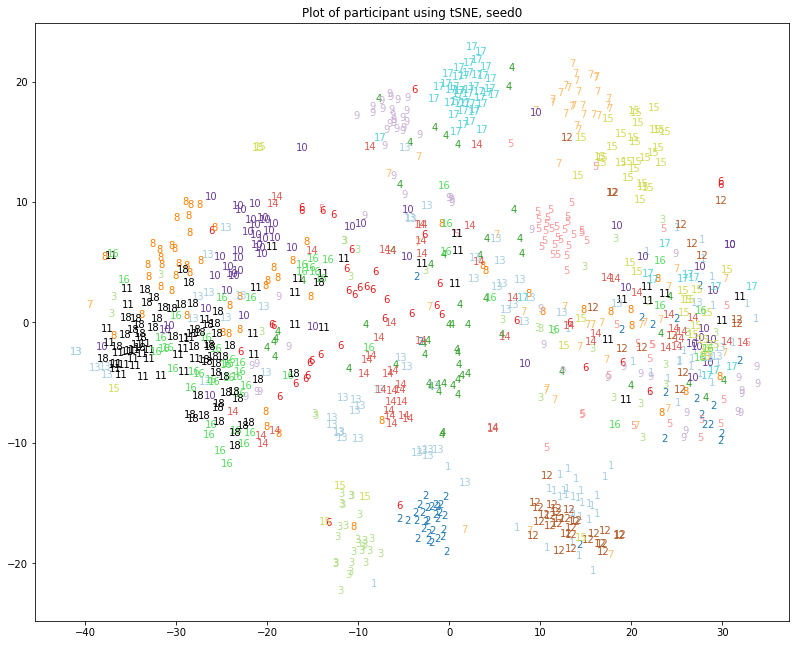

AttributeError: 'DataFrame' object has no attribute 'gcol'

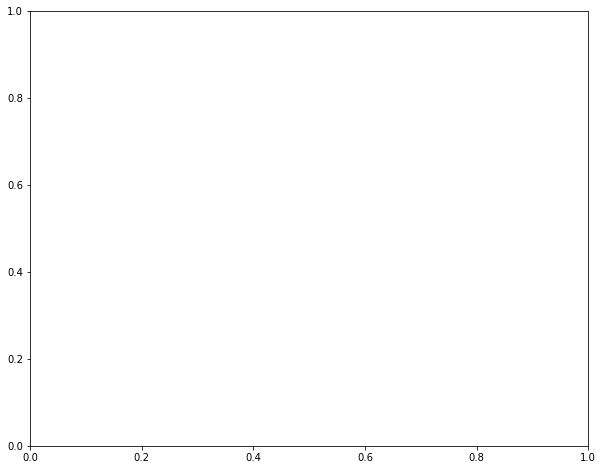

In [202]:
#colors = sns.color_palette("Paired", len(part)+1)
colors = sns.color_palette("Paired", 18)
colors[13:]=sns.color_palette("hls")
cmap = {}
#[cmap.update({z:colors[z]}) for z in np.arange(len(part)+1)]
[cmap.update({z:colors[z]}) for z in np.arange(18)]
colors[10] = (0,0,0)
colors[17] = (0,0,0)

#X2d['c_clust'] = X2d.clusterSC.map(cmap)
X2d['c_part'] = [colors[z-1] for z in X2d.index]

fig, ax = plt.subplots(1, figsize=(13.5,11))
#for x, y, w, t in zip(X2d.dim0, X2d.dim1, X2d.first_sample, X2d.index):
for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.index):
    #plt.text(x, y, w, color=colors[t-1], fontsize=10)
    plt.text(x, y, str(t), color=colors[t-1], fontsize=10)
plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
plt.title("Plot of participant using tSNE, seed" + str(seedno))
plt.show()

fig, ax = plt.subplots(1, figsize=(10,8))
for x, y, t, g in zip(X2d.dim0, X2d.dim1, X2d.index, X2d.gcol):
    plt.text(x, y, str(t), color=g, fontsize=10)
plt.scatter(X2d.dim0, X2d.dim1, c='1', alpha = 0.6, s=10)
plt.title("Plot of participant by perceived gender" + str(seedno))
plt.show()

In [ ]:
# k means
kmeans = KMeans(n_clusters=np.size(sid))
X2d['cluster'] = kmeans.fit_predict(X2d)

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to tSNE cluster pd
xmap = {}
ymap = {}
[xmap.update({z:cen_x[z]}) for z in np.arange(len(cen_x))]
[ymap.update({z:cen_y[z]}) for z in np.arange(len(cen_y))]
X2d['cen_x'] = X2d.cluster.map(xmap)
X2d['cen_y'] = X2d.cluster.map(ymap)

#define and map colors
#based on cluster
colors = sns.color_palette("Paired", len(sid)+2)
cmap = {}
[cmap.update({z:colors[z]}) for z in np.arange(len(cen_x))]
X2d['c_clust'] = X2d.cluster.map(cmap)
X2d['c_part'] = [colors[z] for z in X2d.index]

In [72]:
# plot 
fig, ax = plt.subplots(1, figsize=(14,11))

#plot data
#plt.scatter(X2d.dim0, X2d.dim1, c=X2d.c_part, alpha = 0.6, s=10)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
#plt.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1), loc='upper right')
#plt.title('tSNE plot of clusters\n', loc='left', fontsize=22)

for x, y, t in zip(X2d.dim0, X2d.dim1, X2d.index):
    plt.text(x, y, str(t), color=colors[t], fontsize=12)

#plot centroids
#plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
#plt.scatter(cen_x, cen_y, marker='^', c='k', s=70)

#plot distances
#for idx, val in X2d.iterrows():
#    x = [val.dim0, val.cen_x,]
#    y = [val.dim1, val.cen_y]
    #plt.plot(x, y, c=val.c_clust, alpha=0.2)
#    plt.plot(x, y, c='0.4', alpha=0.2)

plt.show()

In [ ]:
reducer=umap.UMAP()
X2dU =pd.DataFrame(reducer.fit_transform(X), index=y_true, columns = ['dim0', 'dim1'])

# plot 
#fig, ax = plt.subplots()
#fig.set_figheight(7.5)
#fig.set_figwidth(7.5)
#plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
#plt.scatter(*X_2dU.T, c=y_true)
#plt.scatter(*X_2dU[:n,:].T, c=y_true[:n])


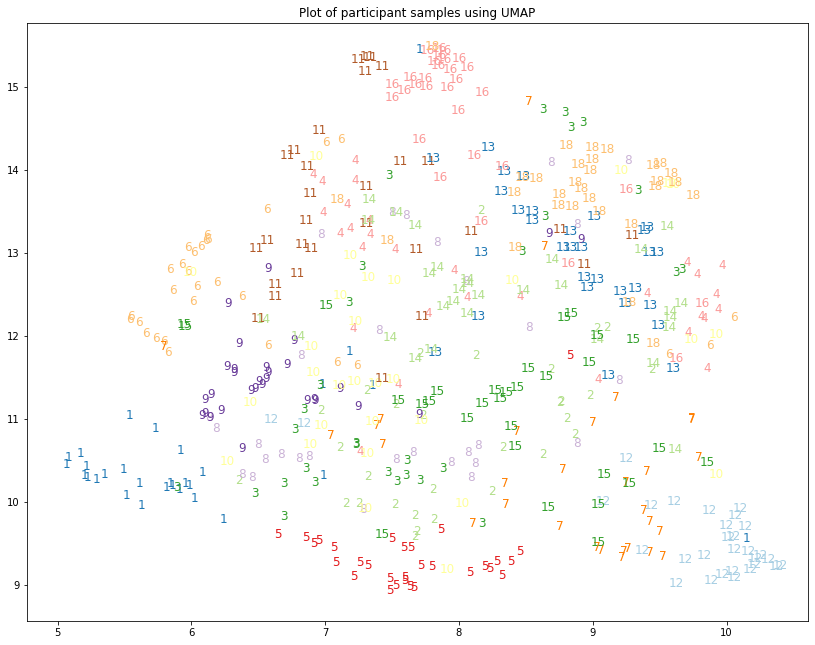

In [93]:
fig, ax = plt.subplots(1, figsize=(14,11))
for x, y, t in zip(X2dU.dim0, X2dU.dim1, X2dU.index):
    plt.text(x, y, str(t), color=colors[t], fontsize=12)
plt.scatter(X2dU.dim0, X2dU.dim1, c='1', alpha = 0.6, s=10)
plt.title("Plot of participant samples using UMAP")
plt.show()